In this post we'll look at eigenfunctions and eigenvalues of the Laplace operator $\Delta$ on a domain $\Omega$ in $\mathbb{R}^d$. 
A function $\phi$ on $\Omega$ and a number $\lambda$ are an eigenfunction/eigenvalue pair if


$$-\Delta\phi = \lambda^2\phi$$

along with the Dirichlet boundary condition $\phi|_{\partial\Omega} = 0$.
The operator $-\Delta$ is symmetric and positive-definite, so the eigenvalues are real and positive.
I've chosen a slightly different way of writing things in terms of $\lambda^2$ because this makes the units of the eigenvalues an inverse length.

The *Weyl asymptotic law* describes how the eigenvalues grow as a function of the domain size and shape.
Weyl proved in 1911 that, if $N(\lambda)$ is the number of eigenvalues of the Dirichlet Laplacian less than $\lambda$, that

$$N(\lambda) = (2\pi)^{-d}\omega_d\cdot\text{vol}(\Omega)\cdot\lambda^{d} + \mathscr{O}(\lambda^{d})$$

as $\lambda \to \infty$, where $\omega_d$ is the volume of the unit ball in $\mathbb{R}^d$.
As a sanity check, note that $\lambda$ has units of length${}^{-1}$, so the formula above is dimensionless.
As another sanity check, you can look at the analytical expression for the eigenvalues on a box or a sphere.
The proof given in volume 1 of Courant and Hilbert is pretty easy to follow.
Weyl conjectured that the second term could be expressed in terms of the area of the boundary:

$$N(\lambda) = (2\pi)^{-d}\omega_d\cdot\text{vol}(\Omega)\cdot\lambda^d - \frac{1}{4}(2\pi)^{1 - d}\omega_{d - 1}\cdot\text{area}(\partial\Omega)\cdot\lambda^{d - 1} + \mathscr{o}\left(\lambda^{d - 1}\right)$$

but this wasn't proved in his lifetime.
Here we'll come up with a simple domain and show how you might verify this law numerically.

### Making a mesh

First, we'll use the package [pygmsh](https://github.com/nschloe/pygmsh) to create the spatial domain.
Pygmsh is a Python wrapper around the mesh generator [gmsh](https://www.gmsh.info); pygmsh adds the nice feature of keeping track of all the entity ID numbers for you.
The domain we'll use will be an ellipse with three circles removed from it.
To keep the repetition down we'll first introduce a helper function that adds an ellipse to an existing geometry.

In [1]:
import numpy as np
from numpy import pi as π
def add_ellipse(geometry, x, y, a, b, N, lcar):
    θs = np.array([2 * π * n / N for n in range(N)])
    xs, ys = x + a * np.cos(θs), y + b * np.sin(θs)
    points = [geometry.add_point([x, y, 0], lcar=lcar) for x, y in zip(xs, ys)]
    lines = [geometry.add_line(points[n], points[(n + 1) % N])
             for n in range(N)]

    geometry.add_physical(lines)
    line_loop = geometry.add_line_loop(lines)
    return line_loop

The following code actually creates the domain.
The calls to add a plane surface and a physical plane surface are easy to forget but essential.

In [2]:
import pygmsh
geometry = pygmsh.built_in.Geometry()

outer_line_loop = add_ellipse(geometry, x=0, y=0, a=2, b=1, N=256, lcar=1/4)
inner_loops = [
    add_ellipse(geometry, x=0, y=1/2, a=1/8, b=1/8, N=128, lcar=1/4),
    add_ellipse(geometry, x=1/2, y=1/4, a=3/16, b=3/16, N=128, lcar=1/4),
    add_ellipse(geometry, x=1, y=-1/4, a=1/4, b=1/4, N=192, lcar=1/4)
]

plane_surface = geometry.add_plane_surface(outer_line_loop, inner_loops)
geometry.add_physical(plane_surface)

with open('ellipse.geo', 'w') as geo_file:
    geo_file.write(geometry.get_code())
    
!gmsh -2 -format msh2 -v 0 -o ellipse.msh ellipse.geo

To make sure everything worked right, we'll visualize the mesh after loading it in.

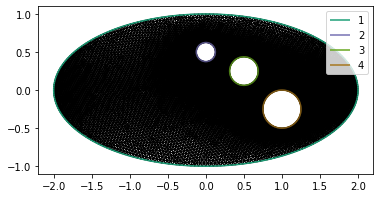

In [3]:
import firedrake
import matplotlib.pyplot as plt
mesh = firedrake.Mesh('ellipse.msh')

fig, axes = plt.subplots()
firedrake.triplot(mesh, axes=axes)
axes.set_aspect('equal')
axes.legend();

### Using SLEPc

To compute the eigenvalues and eigenfunctions of the Laplace operator, we'll use the [Scalable Library for Eigenvalue Problem Computations (SLEPc)](http://slepc.upv.es/).
Both SLEPc and Firedrake are built on top of PETSc, so creating the eigenvalue problem is just a matter of assembling the Firedrake form objects representing our linear operators, extracting the underlying PETSc matrix objects, and passing them to SLEPc.

In [4]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
ϕ = firedrake.TestFunction(Q)
ψ = firedrake.TrialFunction(Q)

from firedrake import inner, grad, dx
a = inner(grad(ϕ), grad(ψ)) * dx
m = ϕ * ψ * dx

bc = firedrake.DirichletBC(Q, 0, 'on_boundary')
A = firedrake.assemble(a, bcs=bc).M.handle
M = firedrake.assemble(m).M.handle

To solve the right problem and to help SLEPc get the right answer we'll pass it several options.
First, we're solving a generalized Hermitian eigenproblem.
Since the eigenproblem is Hermitian, all the eignevalues are real, which is a very convenient simplifying assumption.

For this problem we're going to use a *spectral transformation*.
Rather than find the eigenvalues of a matrix $A$ directly, we'll instead find the eigenvalues of a matrix $f(A)$ where $f$ is invertible and holomorphic on a domain containing the spectrum of $A$.
We can then compute the eigenvalues of $A$ as the function $f^{-1}$ aplied to the eigenvalues of $f(A)$.
The advantage of spectral transformations is that, with a good choice of $f$, the eigenvalues of $f(A)$ can be easier to compute than those of $A$ itself.
Since $A$ is positive-definite and we're looking for the smallest eigenvalues, a good choice is

$$f(z) = 1/(z - \sigma),$$

i.e. shifting and inverting.
This spectral transformation is equivalent to finding the eigendecomposition of $(A - \sigma M)^{-1}$.
Computing the inverse of a matrix is generally a bad idea, but under the hood it's enough to be able to solve linear systems.

Anything in SLEPc having to do with spectral transformations is prefixed with `st`.
In our case, we're using the shift-and-invert transformation (`sinvert`).
To solve these linear systems, we'll a Krylov subspace method (`ksp_type`) with some preconditioner (`pc_type`).
Since $A$ is symmetric and positive-definite, we can use the conjugate gradient method (`cg`).

In [5]:
from petsc4py import PETSc
opts = PETSc.Options()
opts.setValue('eps_gen_hermitian', None)
opts.setValue('eps_target_real', None)
opts.setValue('eps_smallest_real', None)
opts.setValue('st_type', 'sinvert')
opts.setValue('st_ksp_type', 'cg')
opts.setValue('st_pc-type', 'jacobi')
opts.setValue('eps_tol', 1e-8)

In [6]:
from slepc4py import SLEPc
num_values = 250
eigensolver = SLEPc.EPS().create(comm=firedrake.COMM_WORLD)
eigensolver.setDimensions(num_values)
eigensolver.setOperators(A, M)
eigensolver.setFromOptions()
eigensolver.solve()

To check that everything worked right, we can see how many eigenvalues converged:

In [7]:
num_converged = eigensolver.getConverged()
print(num_converged)

288


Just for fun, we can plot one of the eigenfunctions.
The zero contours of eigenfunctions are a fascinating subject -- the Courant nodal domain theorem tells us that the $n$-th eigenfunction can have no more than $n$ nodal domains.

In [8]:
Vr, Vi = A.getVecs()
λ = eigensolver.getEigenpair(24, Vr, Vi)
ϕ = firedrake.Function(Q)
ϕ.vector()[:] = Vr

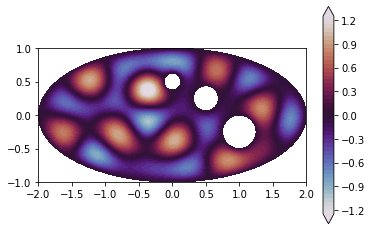

In [9]:
fig, axes = plt.subplots()
levels = np.linspace(-1.25, +1.25, 51)
kwargs = {'levels': levels, 'cmap': 'twilight', 'extend': 'both'}
contours = firedrake.tricontourf(ϕ, axes=axes, **kwargs)
fig.colorbar(contours)
axes.set_aspect('equal');

The following plot shows exact eigenvalue counting function and the order-1 and order-2 approximations from Weyl's law.

In [10]:
Es = np.array([eigensolver.getEigenvalue(k) for k in range(num_values)]).real
λs = np.sqrt(Es)

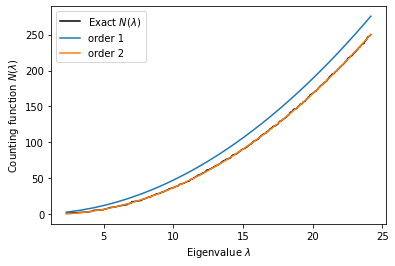

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
Ns = np.array(list(range(len(λs)))) + 1
axes.plot(λs, Ns, color='k', label='Exact $N(\lambda)$')

from firedrake import assemble, Constant, ds
vol = assemble(Constant(1, domain=mesh) * dx)
area = assemble(Constant(1, domain=mesh) * ds)

ω_2 = π
ω_1 = 2
order_1 = 1/(2*π)**2 * ω_2 * vol * λs**2
order_2 = order_1 - 1/(2*π) * ω_1 * area * λs / 4

axes.plot(λs, order_1, color='tab:blue', label='order 1')
axes.plot(λs, order_2, color='tab:orange', label='order 2')
axes.legend()

axes.set_xlabel('Eigenvalue $\lambda$')
axes.set_ylabel('Counting function $N(\lambda)$');

The accuracy difference is even more stark if we look at the relative error in the eigenvalue counting function.

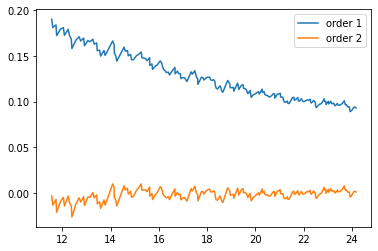

In [12]:
fig, axes = plt.subplots()
error_1 = 1 - Ns / order_1
error_2 = 1 - Ns / order_2
axes.plot(λs[50:], error_1[50:], color='tab:blue', label='order 1')
axes.plot(λs[50:], error_2[50:], color='tab:orange', label='order 2')
axes.legend();

The order-1 approximation is pretty good, but the order-2 approximation is startlingly accurate.
Of course we've only looked at the first few hundred eigenvalues on a mesh with several thousand vertices.
Once the corresponding wavelengths get close to the diameter of a triangle of our mesh, I'd expect the approximation to break down.
The mesh is too coarse at that point to resolve the highly oscillatory eigenfunctions.

### Conclusions

The Weyl asymptotic law has some interesting physical implications.
The first-order version of the law tells us that you can hear the area of a drumhead by fitting the sequence of harmonic frequencies to the right power.
The second-order version of the law tells us that you can, in the same way, hear the perimeter of the drumhead by fitting the remainder of the first-order approximation.

Victor Ivrii gave a proof in 1980 of the Weyl law up to second order, under some special conditions that are thought to hold for a wide class of domains.
While proving the law up to first order is relatively elementary, Ivrii's proof used microlocal analysis, which is well and truly above my pay grade.